# *This graduation project was developed and completed by:*
# *Khalid Alammari*
# *Turki Lughbi*
# *Mohammed Hantool*
# *Hulayyil Faqiri*

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import zscore
drive.mount('/content/drive')


df = pd.read_csv('/content/drive/MyDrive/Projects/Machine Learning for Predicting Heart Disease/Graduation_Project/Cleveland_Synthetic_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Feature                         | Description
-------------------------------|---------------------------------------------------------------
Age                             | Age of the patient in years
sex                             | Gender of the patient (1 = male, 0 = female)
Chest pain type                 | 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic
Resting blood pressure          | Resting blood pressure (in mm Hg)
Serum_Cholesterol               | Serum cholesterol in mg/dl
Fasting_Blood_Sugar            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
Resting electrocardiographic   | 0 = normal, 1 = ST-T abnormality, 2 = left ventricular hypertrophy
Max_Heart_Rate_Achieved         | Maximum heart rate achieved
Exercise_Induced_Angina         | Exercise-induced angina (1 = yes, 0 = no)
ST_Depression_Exercise          | ST depression induced by exercise relative to rest
Peak_Exercise_ST_Segment        | 1 = upsloping, 2 = flat, 3 = downsloping
Num_Major_Vessels_Fluoro        | Number of major vessels (0–3) colored by fluoroscopy
Thalassemia                     | 3 = normal, 6 = fixed defect, 7 = reversible defect
target                          | Presence of heart disease (1 = disease, 0 = no disease)


In [4]:
df.head()

,Unnamed: 0,Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholesterol,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate_Achieved,Exercise_Induced_Angina,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Diagnosis_Heart_Disease
0,1,60,1,4,140,271,0,2,143,1,2.0,2,3,7,1
1,2,39,0,3,126,306,0,0,163,0,0.0,1,0,3,0
2,3,47,1,4,140,256,0,2,126,1,4.2,3,3,7,1
3,4,48,1,3,138,255,0,2,125,1,1.9,1,1,3,0
4,5,55,1,2,120,197,0,0,158,0,0.6,1,0,7,0


In [5]:
df.shape

(5000000, 15)

In [6]:
# Check for missing values in each column
df.isnull().sum()

,0
Unnamed: 0,0
Age,0
Sex,0
Chest_Pain_Type,0
Resting_Blood_Pressure,0
Serum_Cholesterol,0
Fasting_Blood_Sugar,0
Resting_ECG,0
Max_Heart_Rate_Achieved,0
Exercise_Induced_Angina,0


In [35]:
df.duplicated().sum()

np.int64(0)

### Outlier Detection and Visualization

Outliers are data points that significantly differ from other observations. They can be due to measurement errors, data entry errors, or simply natural variations. It's important to identify them as they can disproportionately influence machine learning models.

We will use two common methods:
1.  **Z-score**: Identifies outliers by calculating how many standard deviations a data point is from the mean. A common threshold is a Z-score greater than 3 or less than -3.
2.  **Box Plots**: A graphical representation that displays the distribution of numerical data and can visually highlight outliers (points beyond the 'whiskers').

In [8]:
from scipy.stats import zscore

# Select only numerical columns for Z-score calculation
# Exclude 'Diagnosis_Heart_Disease' if it's the target variable and not a feature for outlier detection
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'Diagnosis_Heart_Disease' in numerical_cols:
    numerical_cols.remove('Diagnosis_Heart_Disease') # Remove target variable from outlier detection features

# Calculate Z-scores for each numerical column
for col in numerical_cols:
    df[f'Zscore_{col}'] = np.abs(zscore(df[col]))

# Define a Z-score threshold (e.g., 3 standard deviations)
threshold = 3

# Identify rows with outliers in at least one numerical feature
outlier_rows_zscore = df[(df[[f'Zscore_{col}' for col in numerical_cols]] > threshold).any(axis=1)]

print(f"Number of outliers detected using Z-score (threshold={threshold}): {len(outlier_rows_zscore)}")
print("First 5 rows of detected outliers (Z-score method):")
display(outlier_rows_zscore[numerical_cols + ['Diagnosis_Heart_Disease']].head())

Number of outliers detected using Z-score (threshold=3): 160777
First 5 rows of detected outliers (Z-score method):


,Unnamed: 0,Age,Sex,Chest_Pain_Type,Resting_Blood_Pressure,Serum_Cholesterol,Fasting_Blood_Sugar,Resting_ECG,Max_Heart_Rate_Achieved,Exercise_Induced_Angina,ST_Depression_Exercise,Peak_Exercise_ST_Segment,Num_Major_Vessels_Flouro,Thalassemia,Diagnosis_Heart_Disease
83,84,63,1,4,120,263,0,0,71,1,1.4,2,1,7,1
96,97,44,1,4,138,315,0,0,120,1,5.6,3,0,7,1
117,118,62,1,4,130,263,0,0,71,0,1.6,2,1,6,0
142,143,62,0,4,138,409,0,2,150,0,1.2,2,0,3,0
175,176,60,0,4,158,407,0,2,150,1,1.9,1,3,7,1


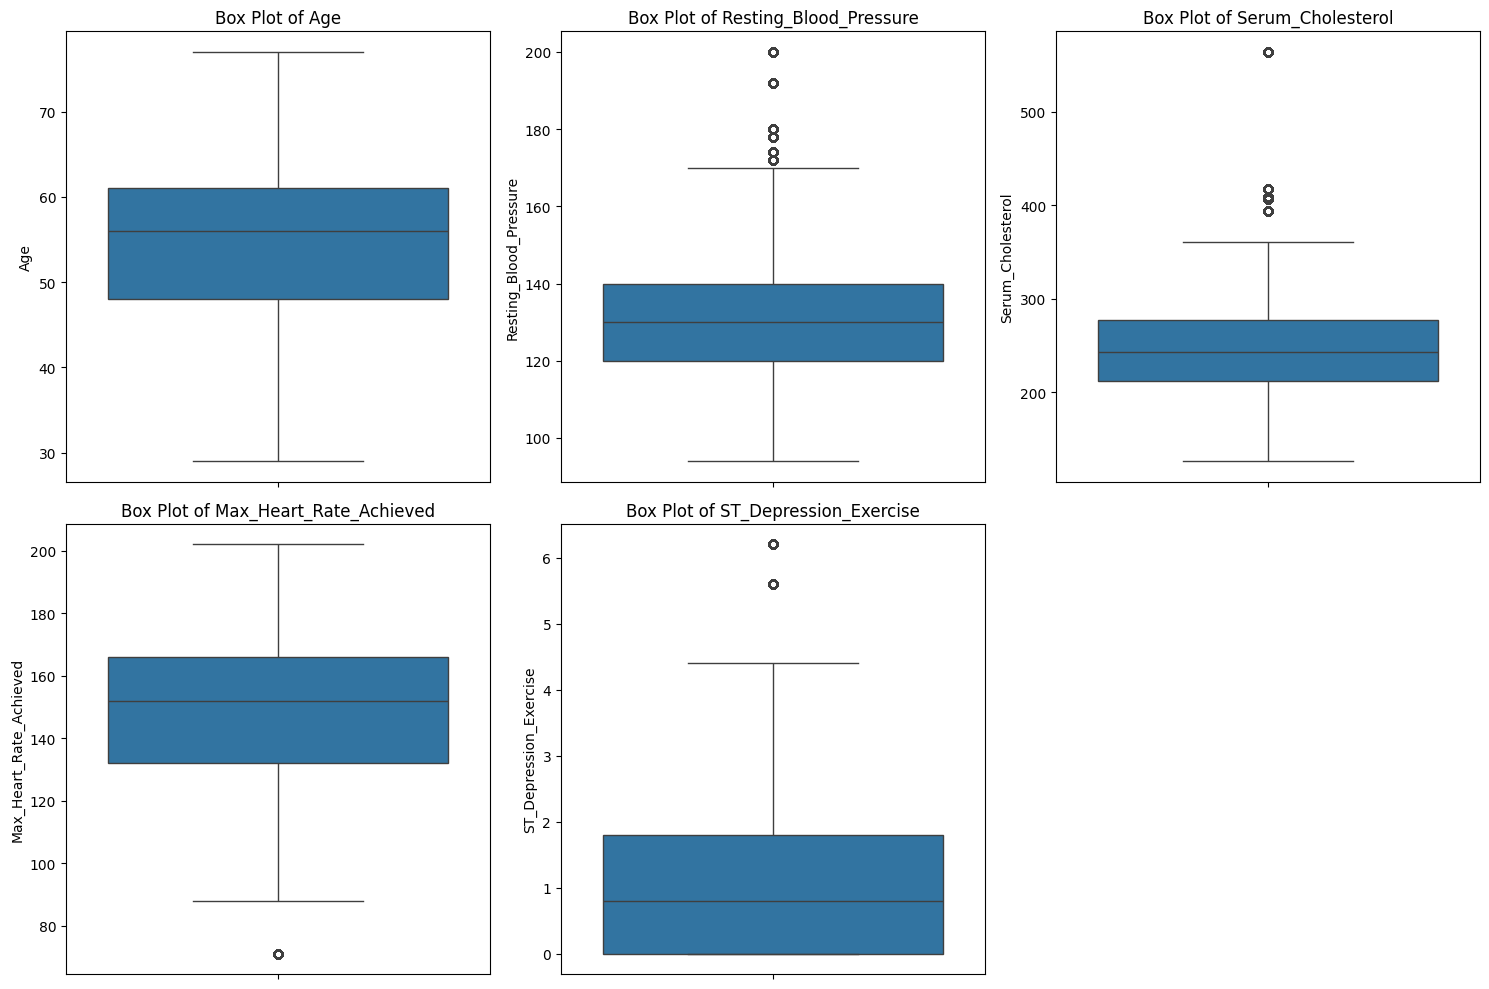

Box plots visually indicating potential outliers (points beyond whiskers).


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize outliers using box plots for selected numerical features
# You might want to adjust the list of columns to visualize based on your data

features_to_plot = ['Age', 'Resting_Blood_Pressure', 'Serum_Cholesterol', 'Max_Heart_Rate_Achieved', 'ST_Depression_Exercise']

plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

print("Box plots visually indicating potential outliers (points beyond whiskers).")

### Outlier Removal: Trimming (Z-score Method)

This method involves removing the rows that were identified as outliers using the Z-score calculation. Be cautious with this approach as it can lead to data loss, especially in smaller datasets.

In [36]:
# Create a new DataFrame `df_cleaned_zscore` by removing the identified outlier rows
# It's good practice to work on a copy to preserve the original DataFrame

# Identify rows that are NOT outliers
non_outlier_rows = df[(df[[f'Zscore_{col}' for col in numerical_cols]] <= threshold).all(axis=1)]
df = non_outlier_rows.copy()
df.shape

KeyError: "None of [Index(['Zscore_Unnamed: 0', 'Zscore_Age', 'Zscore_Sex',\n       'Zscore_Chest_Pain_Type', 'Zscore_Resting_Blood_Pressure',\n       'Zscore_Serum_Cholesterol', 'Zscore_Fasting_Blood_Sugar',\n       'Zscore_Resting_ECG', 'Zscore_Max_Heart_Rate_Achieved',\n       'Zscore_Exercise_Induced_Angina', 'Zscore_ST_Depression_Exercise',\n       'Zscore_Peak_Exercise_ST_Segment', 'Zscore_Num_Major_Vessels_Flouro',\n       'Zscore_Thalassemia'],\n      dtype='object')] are in the [columns]"

### Outlier Handling: Capping (Percentile Method)

Capping involves replacing outlier values with a specified percentile (e.g., 5th percentile for lower bound, 95th percentile for upper bound). This method retains all data points but reduces the impact of extreme values.

Let's apply capping to `Resting_Blood_Pressure` and `Serum_Cholesterol` as examples.

In [11]:
columns_to_cap = ['Resting_Blood_Pressure', 'Serum_Cholesterol', 'Max_Heart_Rate_Achieved', 'ST_Depression_Exercise']

for col in columns_to_cap:
    lower_bound = df[col].quantile(0.01)
    upper_bound = df[col].quantile(0.99)

    # استبدال القيم المتطرفة داخل df نفسه
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])



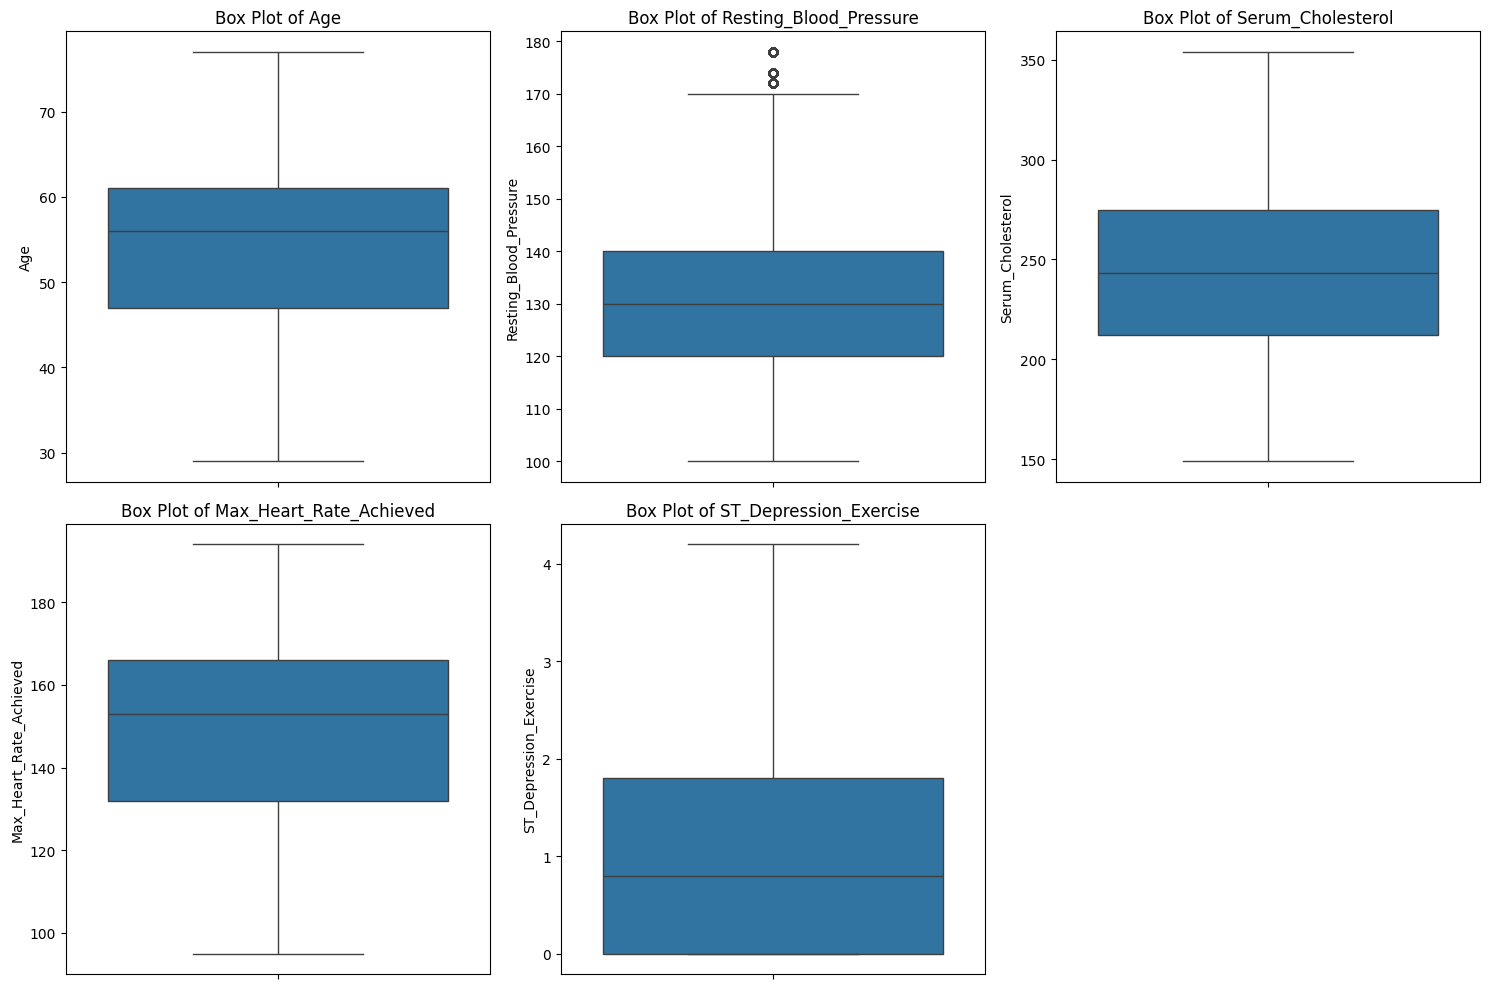

Box plots visually indicating potential outliers (points beyond whiskers).


In [12]:
# Visualize outliers using box plots for selected numerical features
# You might want to adjust the list of columns to visualize based on your data

features_to_plot = ['Age', 'Resting_Blood_Pressure', 'Serum_Cholesterol', 'Max_Heart_Rate_Achieved', 'ST_Depression_Exercise']

plt.figure(figsize=(15, 10))
for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1) # Adjust subplot grid as needed
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

print("Box plots visually indicating potential outliers (points beyond whiskers).")

In [13]:
# Identify all columns that contain the word 'Zscore'
cols_to_drop = [col for col in df.columns if 'Zscore' in col]

# Drop these columns from the main DataFrame
df = df.drop(columns=cols_to_drop)

# Verify the results
print(f"Successfully dropped {len(cols_to_drop)} additional columns.")
print("The remaining columns are:")
print(df.columns.tolist())

Successfully dropped 14 additional columns.
The remaining columns are:
['Unnamed: 0', 'Age', 'Sex', 'Chest_Pain_Type', 'Resting_Blood_Pressure', 'Serum_Cholesterol', 'Fasting_Blood_Sugar', 'Resting_ECG', 'Max_Heart_Rate_Achieved', 'Exercise_Induced_Angina', 'ST_Depression_Exercise', 'Peak_Exercise_ST_Segment', 'Num_Major_Vessels_Flouro', 'Thalassemia', 'Diagnosis_Heart_Disease']


In [14]:
df.shape

(4839223, 15)

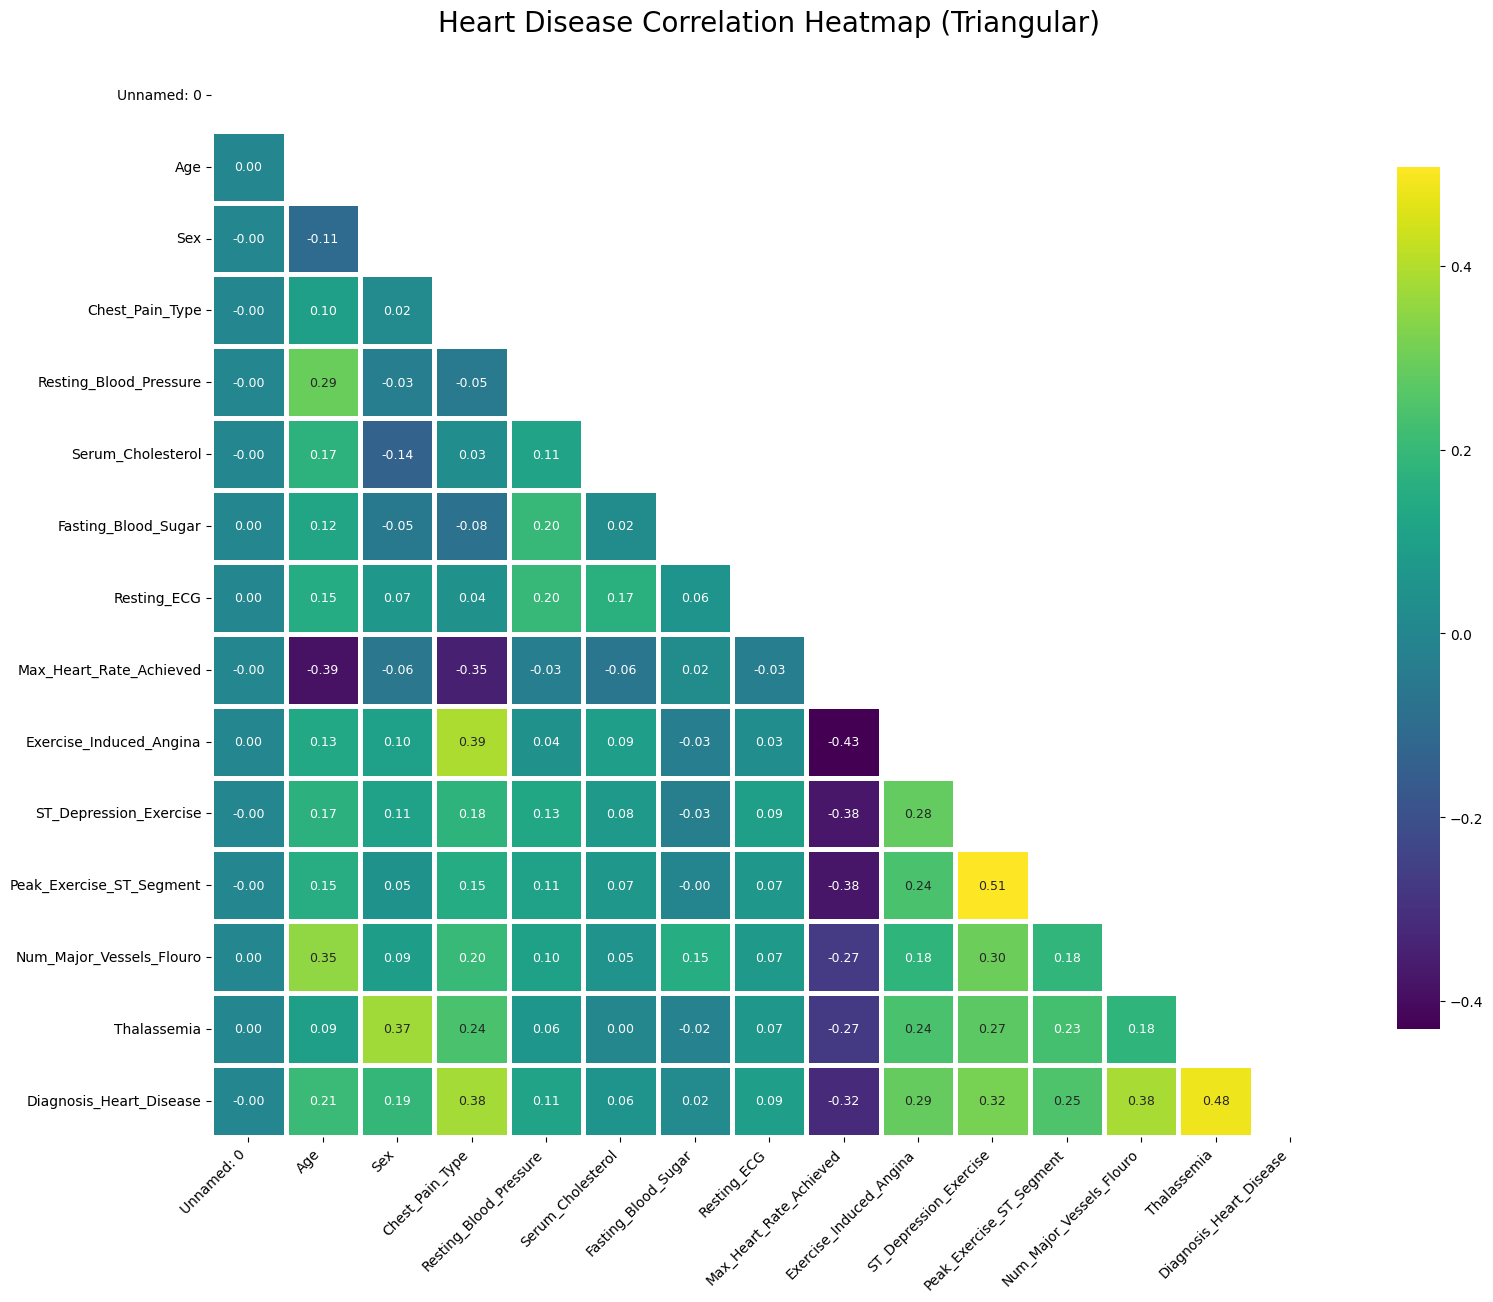

In [33]:
# Calculate the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set the figure size (slightly larger for better spacing)
plt.figure(figsize=(18, 14))

# Create the heatmap
sns.heatmap(corr,
            mask=mask,
            annot=True,
            fmt=".2f",          # Two decimal places for consistency
            cmap='viridis',
            linewidths=2.5,      # Increases the spacing (gap) between squares
            linecolor='white',   # Sets the color of the gap
            annot_kws={"size": 9}, # Adjust font size inside squares if needed
            cbar_kws={"shrink": .8})

plt.title('Heart Disease Correlation Heatmap (Triangular)', fontsize=20, pad=20)
plt.xticks(rotation=45, ha='right') # Rotates labels for better fit
plt.show()

/tmp/ipython-input-3418190048.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Diagnosis_Heart_Disease', data=df, palette={'0': 'blue', '1': 'red'})


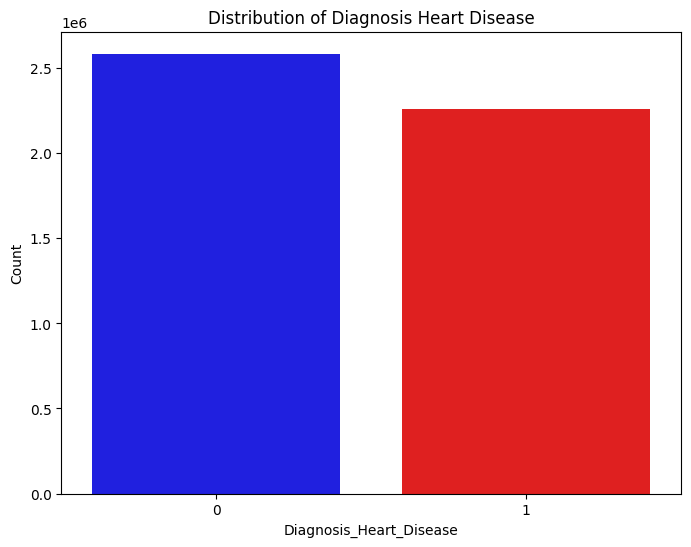

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Diagnosis_Heart_Disease', data=df, palette={'0': 'blue', '1': 'red'})
plt.title('Distribution of Diagnosis Heart Disease')
plt.xlabel('Diagnosis_Heart_Disease')
plt.ylabel('Count')
plt.show()

*The blue bar (no heart disease) is slightly taller than the red bar (heart disease), showing that more individuals in the dataset are healthy than diagnosed.*

*However, the difference is small, which means heart disease is nearly as common as non-disease cases — a sign of high prevalence in the population.*

In [17]:
# show the cout of 1 and 0 in Diagnosis_Heart_Disease
diagnosis_counts = df['Diagnosis_Heart_Disease'].value_counts()
diagnosis_counts

,count
Diagnosis_Heart_Disease,
0,2583371
1,2255852


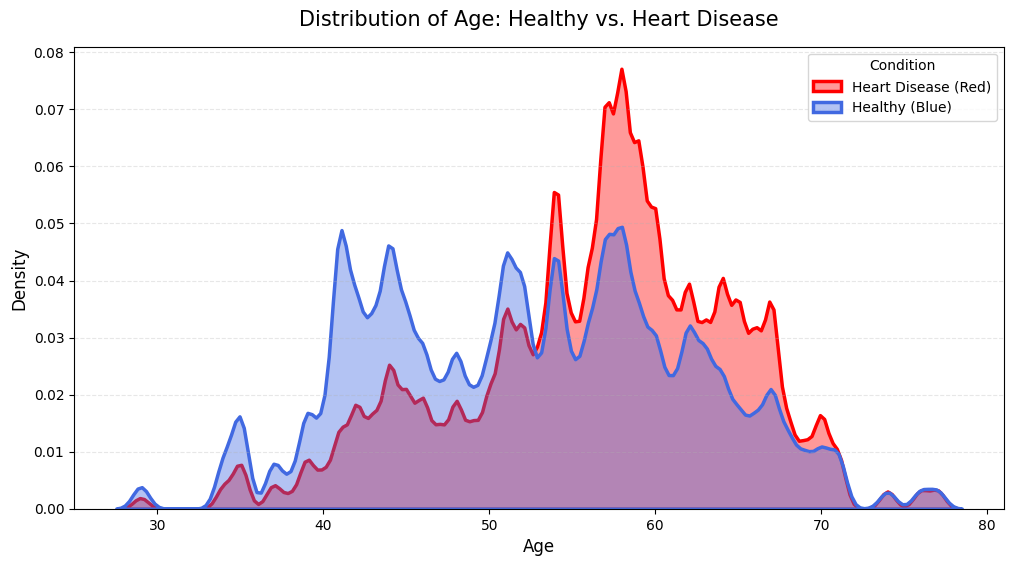

In [18]:
plt.figure(figsize=(12, 6))
custom_palette = {1: "red", 0: "royalblue"}

sns.kdeplot(data=df, x='Age', hue='Diagnosis_Heart_Disease',
            fill=True,
            common_norm=False,
            palette=custom_palette,
            hue_order=[0, 1],
            alpha=0.4,
            linewidth=2.5)

plt.title('Distribution of Age: Healthy vs. Heart Disease', fontsize=15, pad=15)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(title='Condition', labels=['Heart Disease (Red)', 'Healthy (Blue)'])

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

*The red curve (heart disease) peaks around age 58, showing that heart disease is more common in older individuals. The blue curve (healthy) has peaks around ages 42 and 54, suggesting healthier individuals tend to be younger.*

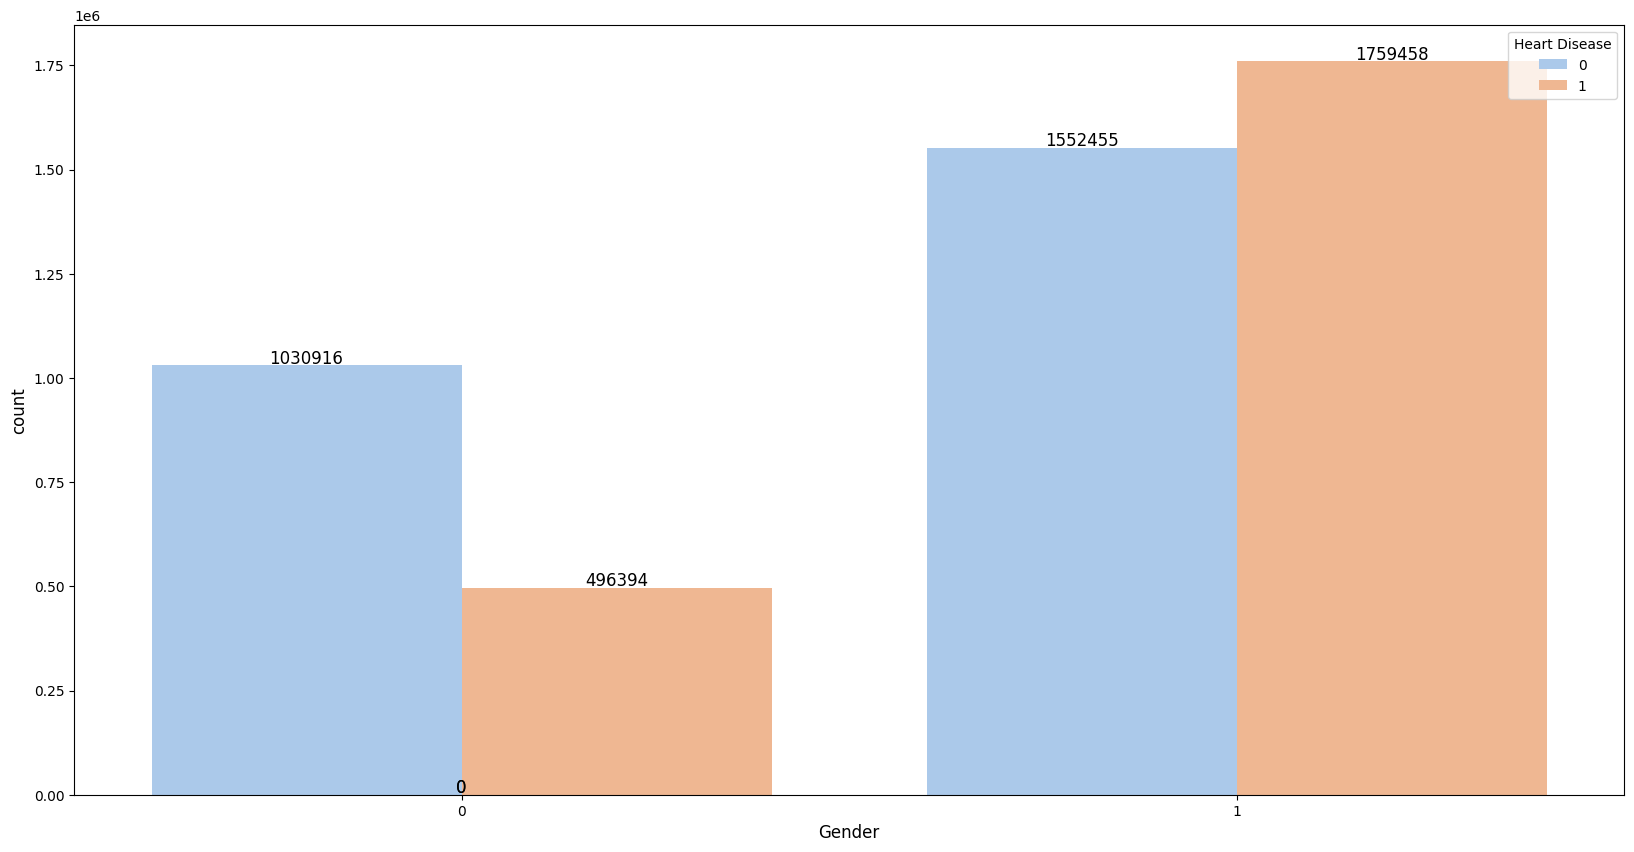

In [19]:
plt.figure(figsize=(20, 10))

ax = sns.countplot(data=df, x='Sex', hue='Diagnosis_Heart_Disease', palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=12)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.legend(title='Heart Disease', loc='upper right')

plt.show()

*Among males (sex = 1), heart disease cases (1,759,458) exceed those without (1,552,455), showing a high prevalence. In contrast, females (sex = 0) have fewer cases (496,394) than non-cases (1,030,916), indicating lower risk.*

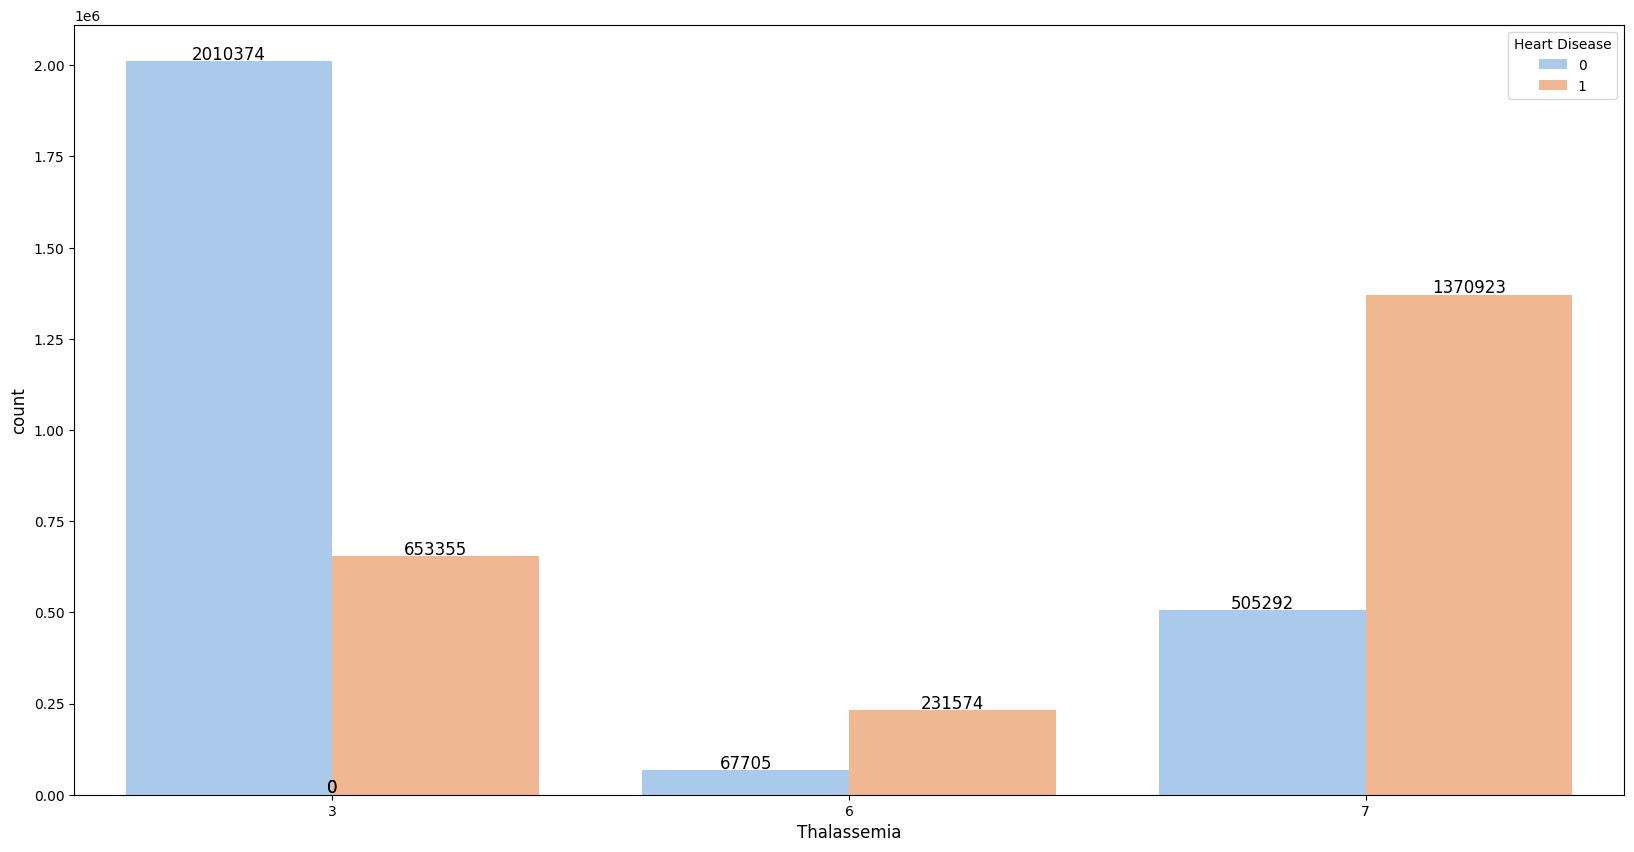

In [20]:
plt.figure(figsize=(20, 10))

ax = sns.countplot(data=df, x='Thalassemia', hue='Diagnosis_Heart_Disease', palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=12)

plt.xlabel('Thalassemia', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.legend(title='Heart Disease', loc='upper right')

plt.show()

 *Type 3 (Normal): Most individuals with this type do not have heart disease, indicating a weak association with the condition.*

*Type 6 (Fixed defect): Shows a moderate association, as the number of affected individuals is higher than those without the disease.*

*Type 7 (Reversible defect): Strongly associated with heart disease, with most individuals in this category being affected, making it an important predictor.*

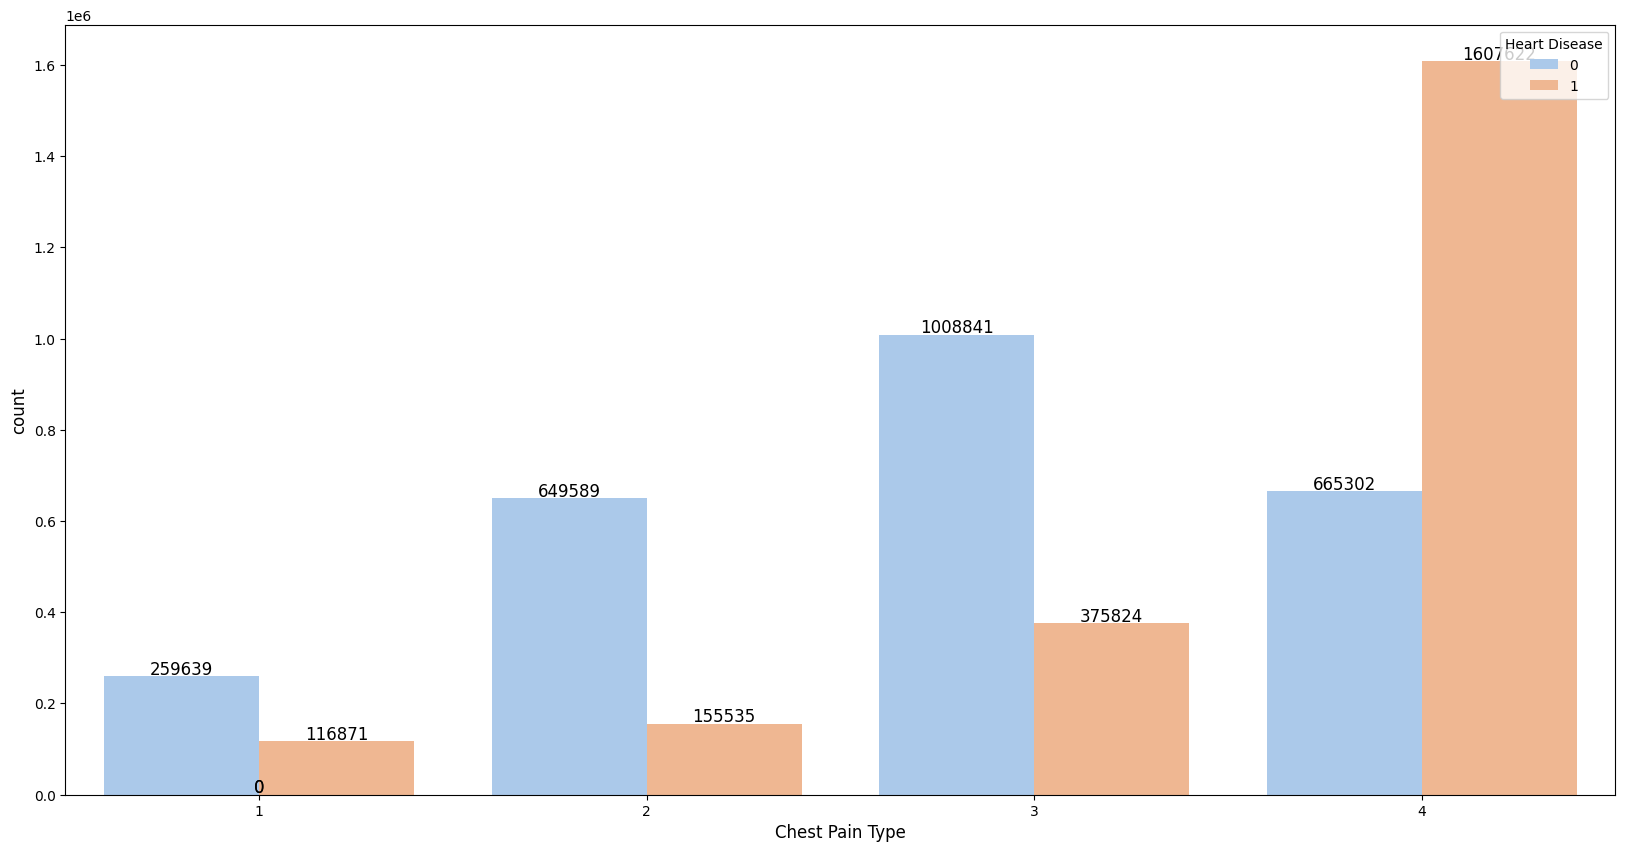

In [21]:
plt.figure(figsize=(20, 10))

ax = sns.countplot(data=df, x='Chest_Pain_Type', hue='Diagnosis_Heart_Disease', palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=12)

plt.xlabel('Chest Pain Type', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.legend(title='Heart Disease', loc='upper right')

plt.show()

*Type 1 (Typical angina): The blue bar is taller than the orange, indicating most individuals with this pain type do not have heart disease.*

*Type 2 (Atypical angina): Also shows more non-cases than cases, but the gap is smaller.*

*Type 3 (Non-anginal pain): The majority are without heart disease, though the orange bar is visibly present.*

*Type 4 (Asymptomatic): The orange bar is dominant, showing a strong link between this pain type and heart disease.*

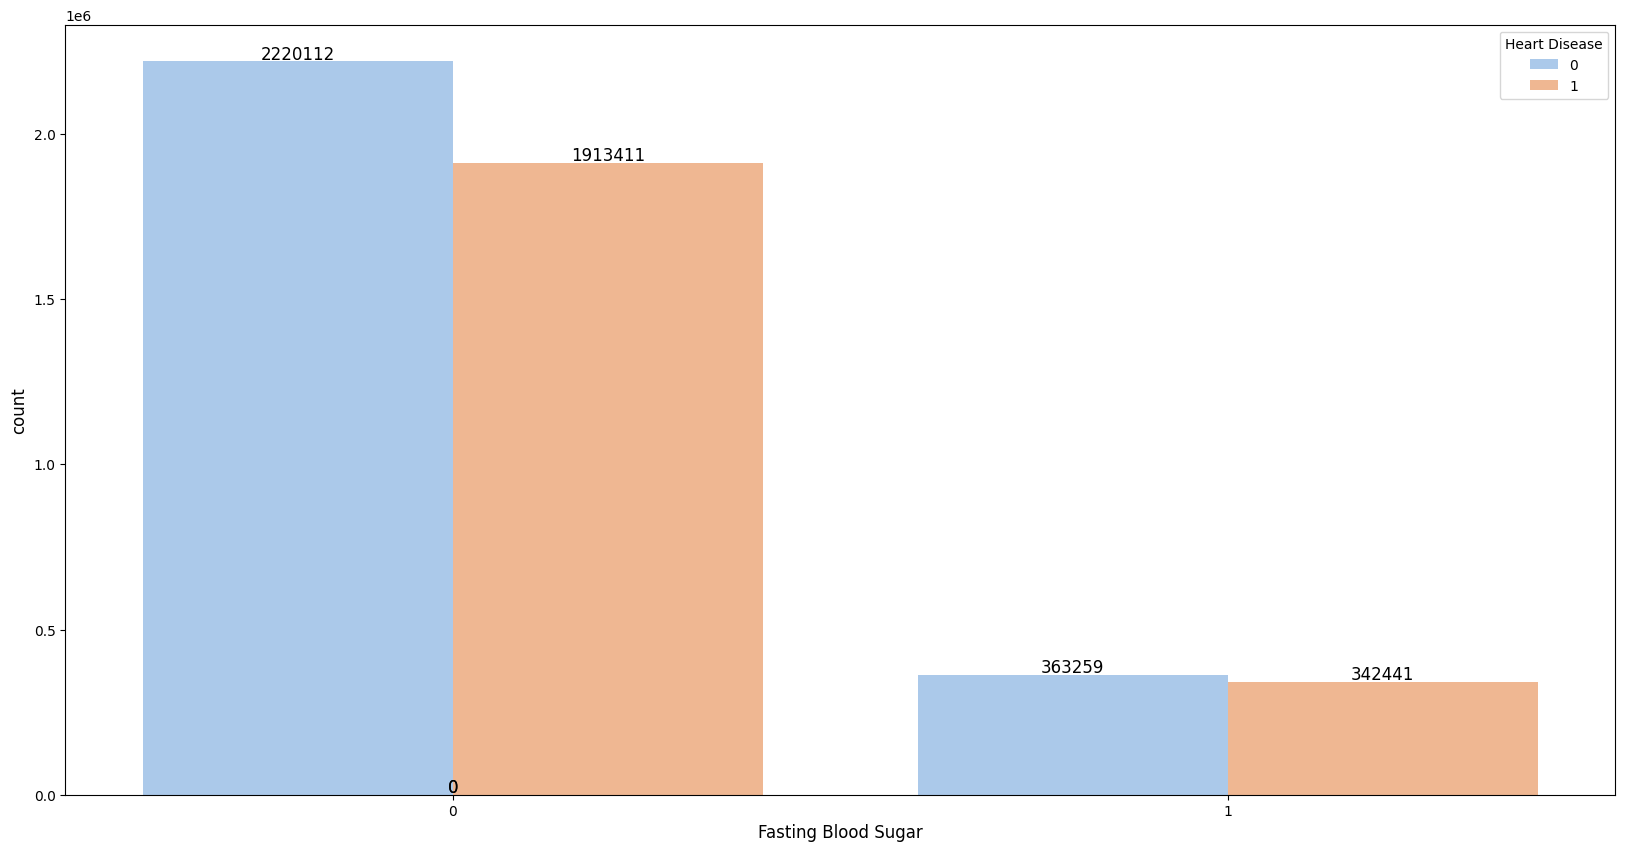

In [22]:
plt.figure(figsize=(20, 10))

ax = sns.countplot(data=df, x='Fasting_Blood_Sugar', hue='Diagnosis_Heart_Disease', palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=12)

plt.xlabel('Fasting Blood Sugar', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.legend(title='Heart Disease', loc='upper right')

plt.show()

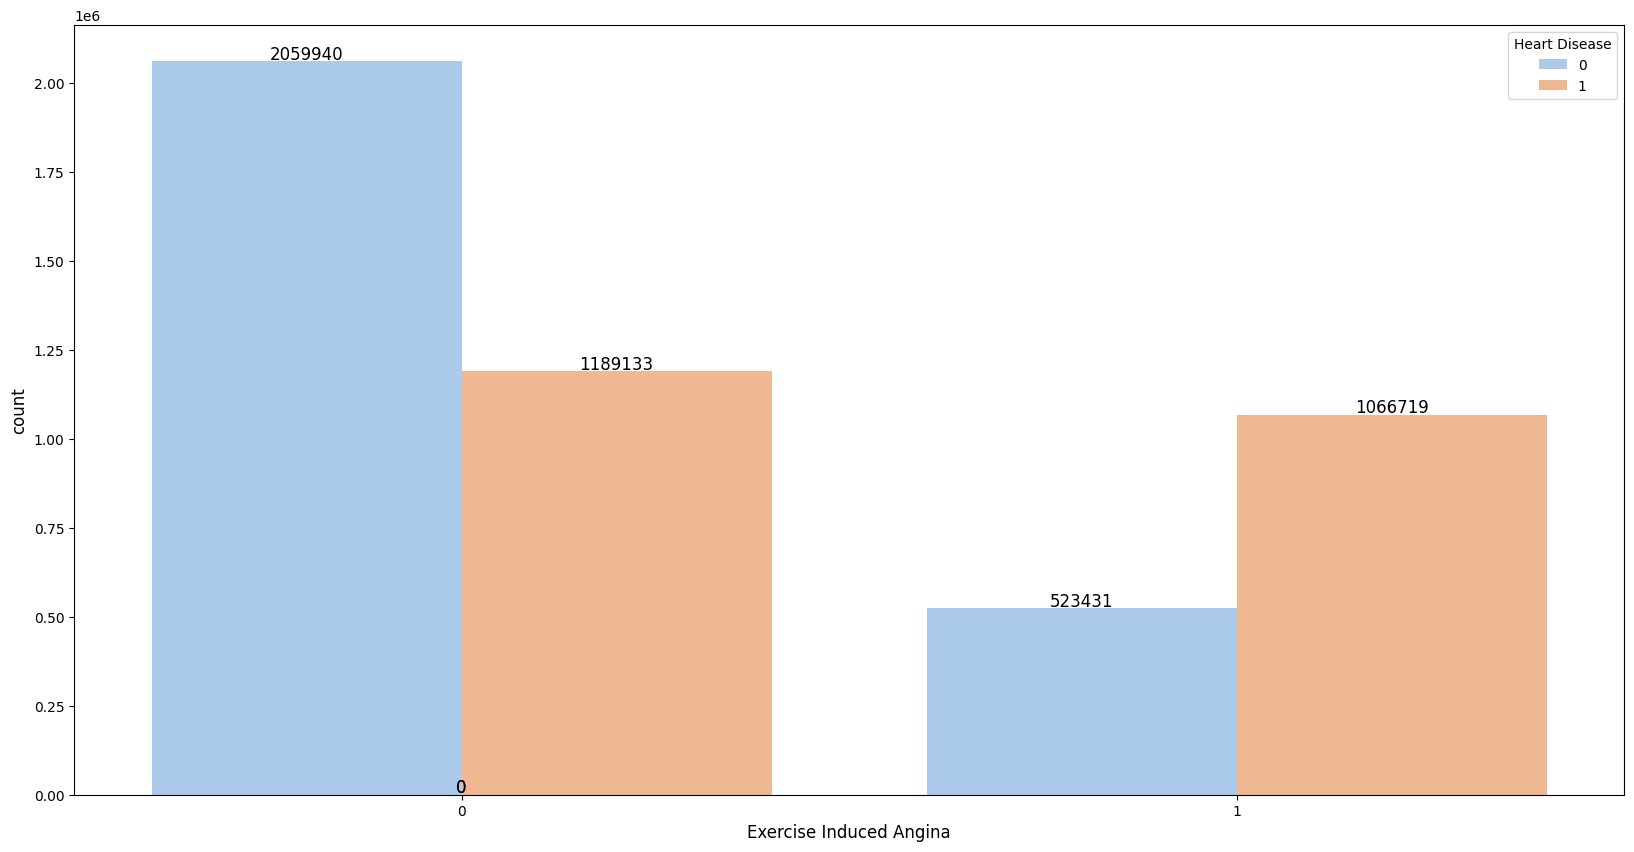

In [23]:
plt.figure(figsize=(20, 10))

ax = sns.countplot(data=df, x='Exercise_Induced_Angina', hue='Diagnosis_Heart_Disease', palette='pastel')

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points',
                fontsize=12)

plt.xlabel('Exercise Induced Angina', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.legend(title='Heart Disease', loc='upper right')

plt.show()

*Angina = 0 (No angina): The blue bar is taller than the orange, meaning most individuals without angina do not have heart disease — though a significant number still do.*

*Angina = 1 (Angina present): The orange bar is taller than the blue, showing that individuals who experience angina during exercise are more likely to have heart disease.*

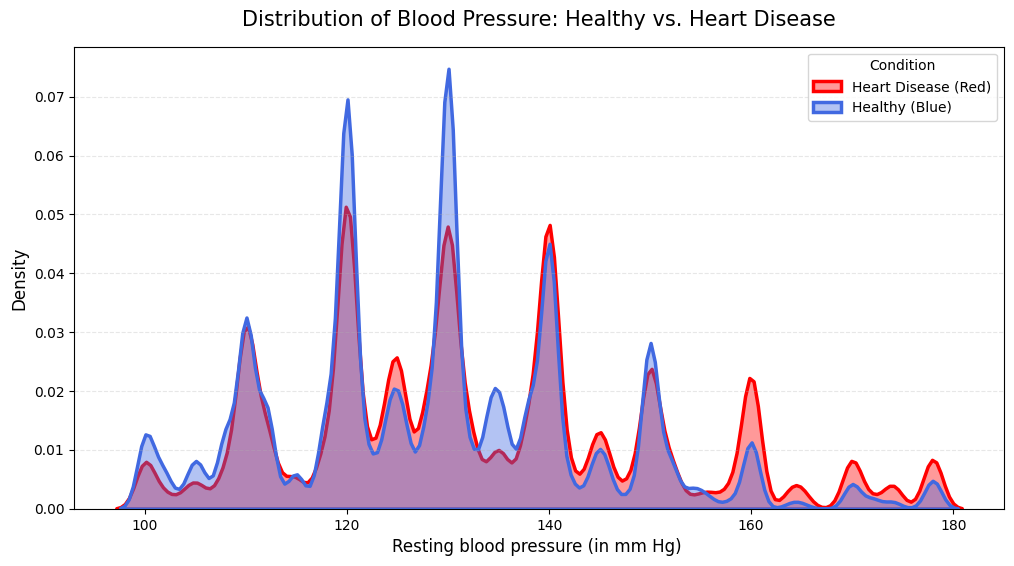

In [24]:
plt.figure(figsize=(12, 6))
custom_palette = {1: "red", 0: "royalblue"}

sns.kdeplot(data=df, x='Resting_Blood_Pressure', hue='Diagnosis_Heart_Disease',
            fill=True,
            common_norm=False,
            palette=custom_palette,
            hue_order=[0, 1],
            alpha=0.4,
            linewidth=2.5)

plt.title('Distribution of Blood Pressure: Healthy vs. Heart Disease', fontsize=15, pad=15)
plt.xlabel('Resting blood pressure (in mm Hg) ', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(title='Condition', labels=['Heart Disease (Red)', 'Healthy (Blue)'])

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

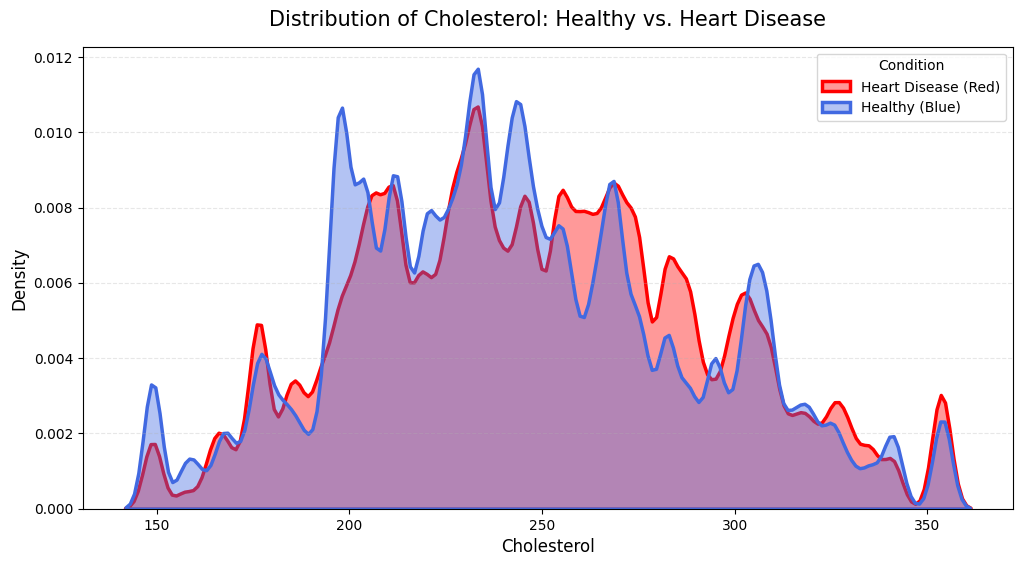

In [25]:
plt.figure(figsize=(12, 6))
custom_palette = {1: "red", 0: "royalblue"}
sns.kdeplot(data=df, x='Serum_Cholesterol', hue='Diagnosis_Heart_Disease',
            fill=True,
            common_norm=False,
            palette=custom_palette,
            hue_order=[0, 1],
            alpha=0.4,
            linewidth=2.5)
plt.title('Distribution of Cholesterol: Healthy vs. Heart Disease', fontsize=15, pad=15)
plt.xlabel('Cholesterol', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(title='Condition', labels=['Heart Disease (Red)', 'Healthy (Blue)'])

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

*The red curve (heart disease) shows a wider spread and peaks at higher cholesterol levels than the blue curve (healthy). This suggests that individuals with heart disease tend to have elevated cholesterol compared to healthy individuals.*

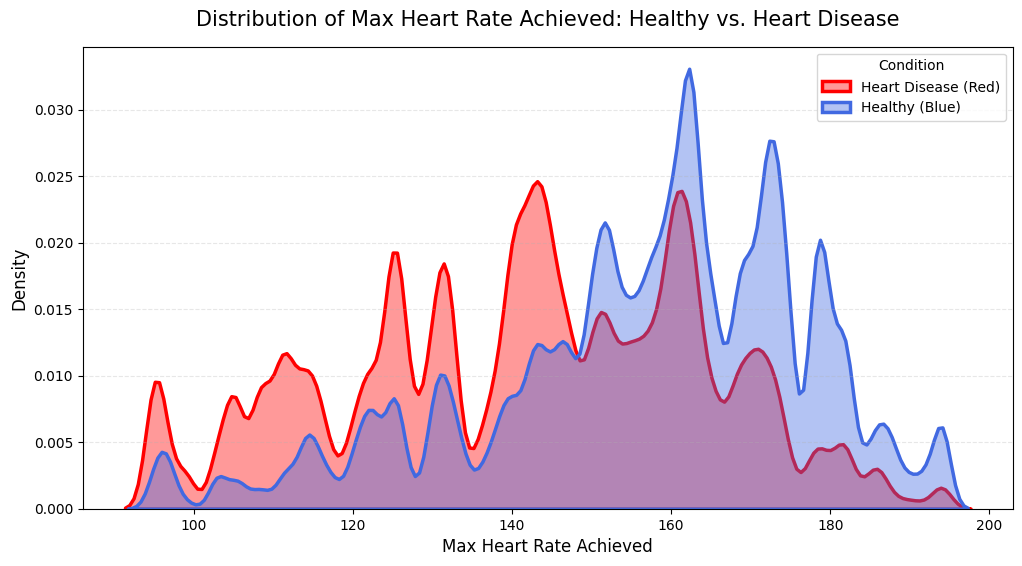

In [26]:
plt.figure(figsize=(12, 6))
custom_palette = {1: "red", 0: "royalblue"}
sns.kdeplot(data=df, x='Max_Heart_Rate_Achieved', hue='Diagnosis_Heart_Disease',
            fill=True,
            common_norm=False,
            palette=custom_palette,
            hue_order=[0, 1],
            alpha=0.4,
            linewidth=2.5)
plt.title('Distribution of Max Heart Rate Achieved: Healthy vs. Heart Disease', fontsize=15, pad=15)
plt.xlabel('Max Heart Rate Achieved', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.legend(title='Condition', labels=['Heart Disease (Red)', 'Healthy (Blue)'])

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [27]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


X = df.drop(columns=['Diagnosis_Heart_Disease'])
y = df['Diagnosis_Heart_Disease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [28]:
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBClassifier Accuracy: {accuracy:.2f}')

# Print classification report
print(classification_report(y_test, y_pred))

# Feature importance
print("Feature Importance:")
print(model.feature_importances_)

XGBClassifier Accuracy: 0.87
              precision    recall  f1-score   support

           0       0.86      0.89      0.88    517165
           1       0.87      0.83      0.85    450680

    accuracy                           0.87    967845
   macro avg       0.87      0.86      0.86    967845
weighted avg       0.87      0.87      0.86    967845

Feature Importance:
[1.2950173e-04 1.2161252e-04 1.4378622e-04 2.4972354e-01 1.3457296e-02
 3.7789252e-03 1.3196399e-04 1.2754292e-04 5.2328128e-03 1.1765673e-04
 1.4732274e-02 2.6266312e-02 1.2654199e-01 5.5949473e-01]


In [ ]:
#from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
#rf_model = RandomForestClassifier(random_state=42)

# Train the model
#rf_model.fit(X_train, y_train)

# Make predictions on the test set
#rf_y_pred = rf_model.predict(X_test)

# Evaluate the model
#rf_accuracy = accuracy_score(y_test, rf_y_pred)
#print(f'Random Forest Accuracy: {rf_accuracy:.2f}')

# Print classification report
#print(classification_report(y_test, rf_y_pred))

In [30]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
logreg_model = LogisticRegression(random_state=42)

# Train the model
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
logreg_y_pred = logreg_model.predict(X_test)

# Evaluate the model
logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
print(f'Logistic Regression Accuracy: {logreg_accuracy:.2f}')

# Print classification report
print(classification_report(y_test, logreg_y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.69
              precision    recall  f1-score   support

           0       0.71      0.72      0.71    517165
           1       0.67      0.67      0.67    450680

    accuracy                           0.69    967845
   macro avg       0.69      0.69      0.69    967845
weighted avg       0.69      0.69      0.69    967845



In [32]:
# Ann
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],))) # Input layer
model.add(Dense(32, activation='relu')) # Hidden layer
model.add(Dense(1, activation='sigmoid')) # Output layer (sigmoid for binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test)) # Adjust epochs and batch size as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'ANN Accuracy: {accuracy:.2f}')

# Make predictions
y_pred_ann = model.predict(X_test)
y_pred_ann = (y_pred_ann > 0.5).astype(int) # Convert probabilities to binary predictions

# Print classification report
print(classification_report(y_test, y_pred_ann))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 345s 3ms/step - accuracy: 0.5200 - loss: 556.5118 - val_accuracy: 0.5344 - val_loss: 0.6909
Epoch 2/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 363s 3ms/step - accuracy: 0.5334 - loss: 0.7283 - val_accuracy: 0.5344 - val_loss: 0.6909
Epoch 3/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 346s 3ms/step - accuracy: 0.5338 - loss: 0.7049 - val_accuracy: 0.5344 - val_loss: 0.6908
Epoch 4/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 344s 3ms/step - accuracy: 0.5340 - loss: 0.6930 - val_accuracy: 0.5344 - val_loss: 0.6908
Epoch 5/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 344s 3ms/step - accuracy: 0.5332 - loss: 0.7233 - val_accuracy: 0.5344 - val_loss: 0.6908
Epoch 6/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 344s 3ms/step - accuracy: 0.5337 - loss: 0.7019 - val_accuracy: 0.5344 - val_loss: 0.6909
Epoch 7/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 340s 3ms/step - accuracy: 0.5339 - loss: 0.6985 - val_accuracy: 0.5344 - val_loss: 0.6908
Epoch 8/10
120981/120981 ━━━━━━━━━━━━━━━━━━━━ 